In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr

from discontinuum.providers import usgs
from discontinuum.utils import aggregate_to_daily

In [2]:
# setup

# Choptank River at Greensboro, MD
# site = "01491000"
# start_date = "1979-10-01"
# end_date = "2011-09-30"

# SF Coeur D Alene River
site = "12413470"
start_date = "1988-10-01"
end_date = "2021-09-30"

characteristic = "Inorganic nitrogen (nitrate and nitrite)"
# characteristic = 'Phosphorus'
fraction = "Dissolved"

In [3]:
# download data

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples = usgs.get_samples(
    site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction
)

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join="inner")

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/discontinuum/providers/usgs.py:254: UserWarning: Censored values have been removed from the dataset.
  warnings.warn("Censored values have been removed from the dataset.")


In [4]:
training_data["flux"] = training_data["concentration"] * training_data["flow"] * 86400 * 1e-6  # kg/day
training_data["flux"].attrs = training_data["concentration"].attrs
training_data["flux"].attrs["units"] = "kg per day"

In [5]:
%%time
# fit model

from discontinuum.models import LoadestGP

model = LoadestGP()
model.fit(target=training_data["flux"], covariates=training_data[["time", "flow"]])
# model.fit(target=training_data['concentration'], covariates=training_data[['time','flow']])

MAP ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:01:23 logp = -98.655, ||grad|| = 0.028207

CPU times: user 7.88 s, sys: 1.83 s, total: 9.71 s
Wall time: 16.4 s


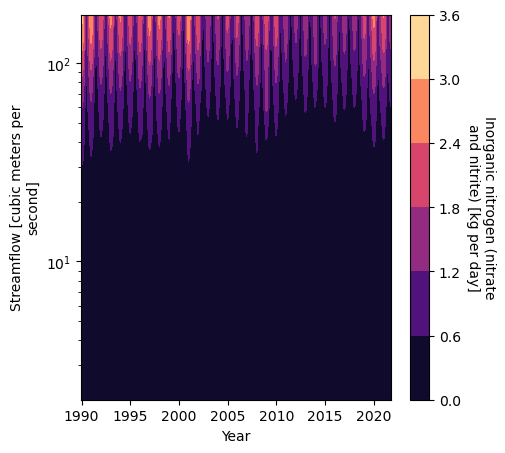

In [6]:
model.contourf(cmap="magma", levels=5)
plt.show()

# counter factual experiment
pick one year period and repeat that flow throughout
then compute the load sans residual
then compute residual load with original flow

In [7]:
# get period 1
# counterfactual_period 1990-2021
# counterfactual_year = 1990
p0 = daily[["time", "flow"]].sel(time=slice("1990", "2021"))  # full period
p1 = daily[["time", "flow"]].sel(time=slice("1990", "1990"))  # conditioning period
q0 = p0["flow"].values
q1 = p1["flow"].values

# q2 = np.repeat(q, 2)
# q2.shape

In [8]:
import numpy as np

n0 = q0.shape[0]
n1 = q1.shape[0]
rep = np.ceil(n0 / n1)
q_temp = np.repeat(q1, rep)
q1 = q_temp[:n0]  # counterfactual flow (repeating p1)

In [9]:
## THIS MIGHT BE WRONG
# trend load
# take flow from p1 and combine with time from p2
p2 = p0.copy()
p2["flow"].values = q1

Xcounter = model.dm.Xnew(p2)
Xoriginal = model.dm.Xnew(p0)
# Xnew = model.dm.Xnew(p2)

In [10]:
mu = {}
cov = {}
for k in ["trend", "seasonal", "covariates"]:
    mu[k], cov[k] = model.gp_kernels[k].predict(
        Xcounter,
        point=model.mp,
        diag=False,
        given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
        model=model.model,
    )

k = "res"
mu[k], cov[k] = model.gp_kernels[k].predict(
    Xoriginal,
    point=model.mp,
    diag=False,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)

AttributeError: 'LoadestGP' object has no attribute 'gp_kernels'

In [16]:
rng = np.random.default_rng()
tol = 1e-6
n = 1000
method = "cholesky"
sim = 0

for k in mu.keys():
    print(k)
    sim += rng.multivariate_normal(mu[k], cov[k], size=n, method=method, tol=tol)

trend
seasonal
covariates
res


In [38]:
# sim.mean(axis=0)
model.dm.y_t(sim)

temp = model.dm.y_t(sim)
data = temp.data.reshape(n, -1)
attrs = temp.attrs
da = xr.DataArray(
    data,
    coords={"time": p0.time, "draw": np.arange(n)},
    dims=["draw", "time"],
    attrs=attrs,
)

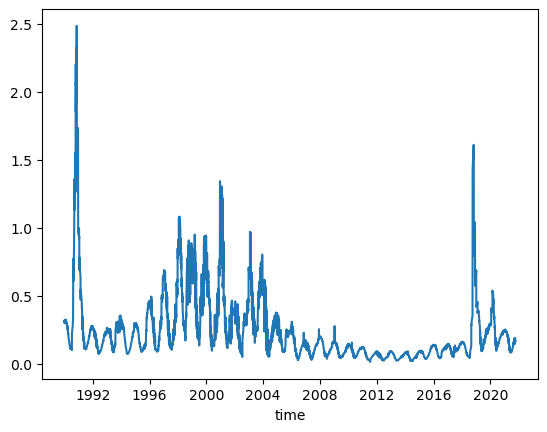

In [39]:
da.mean(dim="draw").plot()

In [40]:
flux = da

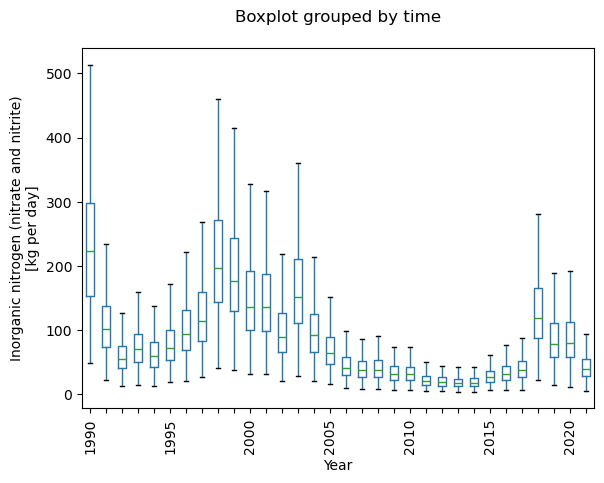

In [41]:
# compute load then do
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
annual_flux = flux.resample(time="YE").sum()

# plot
annual_flux.to_dataframe(name="load").boxplot(by="time", showfliers=False, grid=False, ax=ax)
ax.set_ylabel("{}\n[{}]".format(flux.attrs["long_name"], flux.attrs["units"]))
ax.set_xlabel("Year")
ax.tick_params(axis="x", labelrotation=90)

# label every 5th year
labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual_flux.time.dt.year.values)]
ax.set_xticklabels(labels)
ax.set_title("")

plt.show()

In [ ]:
# now construct a new model simulating from each of these

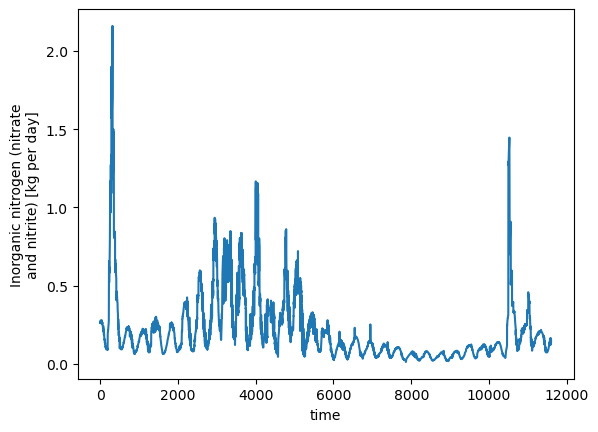

In [270]:
# trend = model.dm.y_t(mu_trend+mu_seasonal+mu_covariates+mu_res).plot()

In [273]:
flux = model.sample(daily[["time", "flow"]])

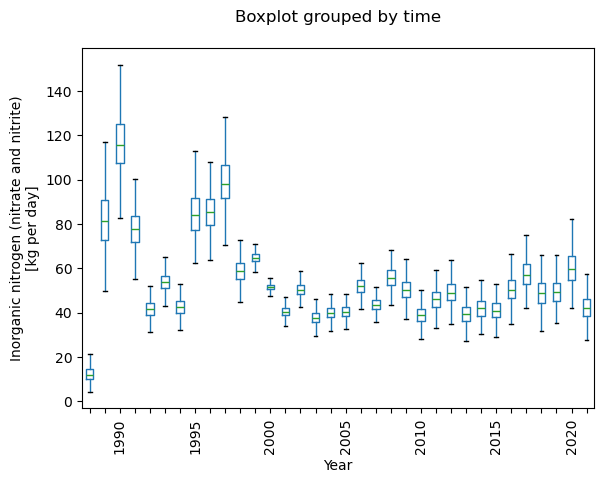

In [274]:
# compute load then do
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
annual_flux = flux.resample(time="YE").sum()

# plot
annual_flux.to_dataframe(name="load").boxplot(by="time", showfliers=False, grid=False, ax=ax)
ax.set_ylabel("{}\n[{}]".format(flux.attrs["long_name"], flux.attrs["units"]))
ax.set_xlabel("Year")
ax.tick_params(axis="x", labelrotation=90)

# label every 5th year
labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual_flux.time.dt.year.values)]
ax.set_xticklabels(labels)
ax.set_title("")

plt.show()

# NOTES

In [ ]:
# TODO
# for the original data period
# compute the residual load and save for later
resid_load = true_load - trend_load

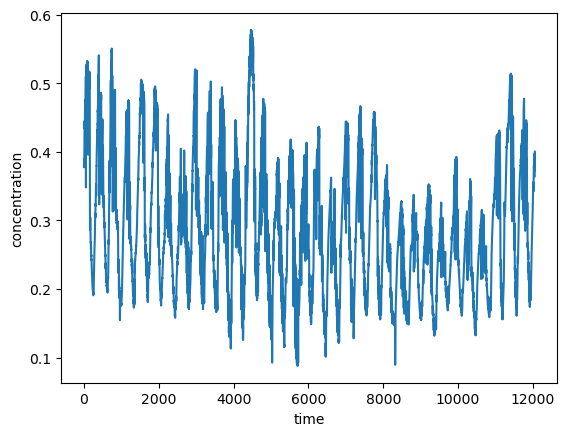

In [240]:
# now compute the counterfactual trend load

cf_load = cf_trend_load + resid_load

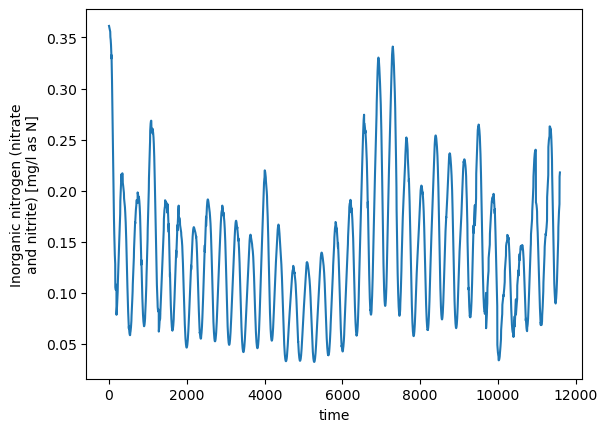

In [230]:
# partial counterfactual
model.dm.y_t(mu_trend + mu_seasonal + mu_covariates).plot()

# scratch

In [164]:
print("Predicting with gp_res ...")
Xnew = model.dm.Xnew(daily[["time", "flow"]])

mu_trend, var = model.gp_trend.predict(
    # Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
    Xnew,
    point=model.mp,
    diag=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)
mu_res, var = model.gp_res.predict(
    # Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
    Xnew,
    point=model.mp,
    diag=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)
mu_covariates, var = model.gp_covariates.predict(
    # Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
    Xnew,
    point=model.mp,
    diag=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)
mu_seasonal, var = model.gp_seasonal.predict(
    # Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
    Xnew,
    point=model.mp,
    diag=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)

Predicting with gp_res ...


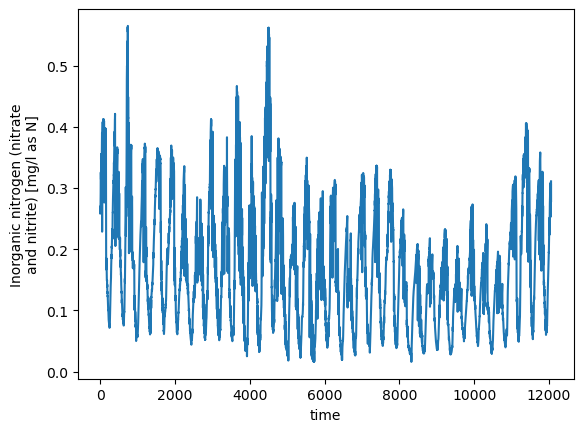

In [169]:
model.dm.y_t(mu_trend + mu_seasonal + mu_covariates + mu_res).plot()

In [184]:
# okay the basics are working so let's set up the scenario

# get period 1
p1 = daily[["time", "flow"]].sel(time=slice("1990", "1995"))
p2 = daily[["time", "flow"]].sel(time=slice("2015", "2020"))
# make the same length
p2 = p2.isel(time=slice(None, -1))

In [191]:
p1["flow"].values

array([ 8.2401888,  8.4100896,  8.211872 , ..., 13.2239456, 13.308896 ,
       13.025728 ])

In [193]:
# trend load
# take flow from p1 and combine with time from p2
p3 = p2.copy()
p3["flow"].values = p1["flow"].values

Xnew = model.dm.Xnew(p3)

mu_trend, var = model.gp_trend.predict(
    # Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
    Xnew,
    point=model.mp,
    diag=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)
# mu_res, var = model.gp_res.predict(
#    #Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
#    Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0}, model=model.model
# )
mu_covariates, var = model.gp_covariates.predict(
    # Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
    Xnew,
    point=model.mp,
    diag=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)
mu_seasonal, var = model.gp_seasonal.predict(
    # Xnew, point=model.mp, diag=True, given={"gp": model.gp, "X": t, "y": y, "noise": cov_noise}
    Xnew,
    point=model.mp,
    diag=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0},
    model=model.model,
)

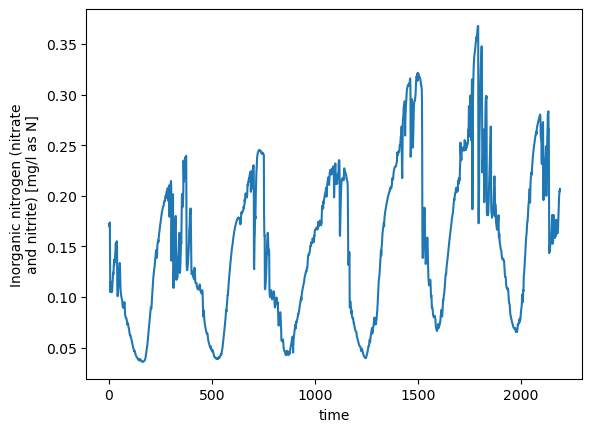

In [194]:
cf_trend = model.dm.y_t(mu_trend + mu_seasonal + mu_covariates).plot()
# okay great now compute laod of this

In [185]:
# compute the residual load
p_res = p1

<xarray.Dataset> Size: 35kB
Dimensions:  (time: 2191)
Coordinates:
  * time     (time) datetime64[ns] 18kB 1990-01-01 1990-01-02 ... 1995-12-31
Data variables:
    flow     (time) float64 18kB 8.24 8.41 8.212 8.184 ... 13.22 13.31 13.03
Attributes:
    id:         12413470
    name:       SF Coeur D Alene River nr Pinehurst, ID
    latitude:   47.5513111
    longitude:  -116.2362917

In [186]:
p2

<xarray.Dataset> Size: 35kB
Dimensions:  (time: 2191)
Coordinates:
  * time     (time) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2020-12-30
Data variables:
    flow     (time) float64 18kB 7.362 8.07 8.014 7.759 ... 7.759 7.277 6.994
Attributes:
    id:         12413470
    name:       SF Coeur D Alene River nr Pinehurst, ID
    latitude:   47.5513111
    longitude:  -116.2362917

<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [kg per day]'>

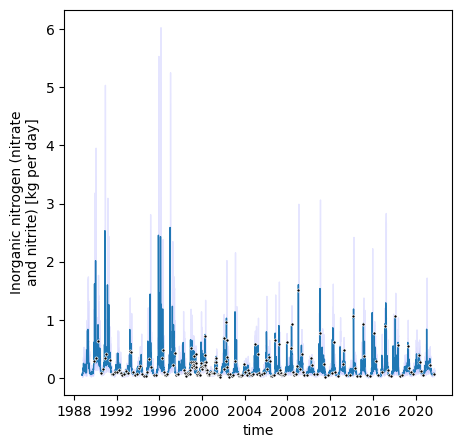

In [249]:
# plot result

model.plot(daily[["time", "flow"]])

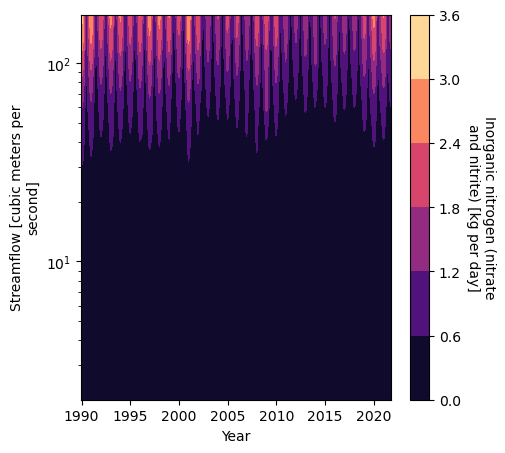

In [250]:
#  plot
model.contourf(cmap="magma", levels=5)
plt.show()

In [ ]:
sim = model.sample(daily[["time", "flow"]])

In [ ]:
flux = sim * daily["flow"] * 86400 * 1e-6  # kg/day
flux.attrs = samples["concentration"].attrs
flux.attrs["units"] = "kilotons N per year"

In [ ]:
# compute load then do
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
annual_flux = flux.resample(time="YE").sum()

# plot
annual_flux.to_dataframe(name="load").boxplot(by="time", showfliers=False, grid=False, ax=ax)
ax.set_ylabel("{}\n[{}]".format(flux.attrs["long_name"], flux.attrs["units"]))
ax.set_xlabel("Year")
ax.tick_params(axis="x", labelrotation=90)

# label every 5th year
labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual_flux.time.dt.year.values)]
ax.set_xticklabels(labels)
ax.set_title("")

plt.show()

In [ ]:
fig, ax = plt.subplots()

flux_5yr = annual_flux.rolling(time=5).mean()
flux_5yr["time"] = flux_5yr.time.dt.year
flux_5yr.to_dataframe(name="load").boxplot(by="time", showfliers=False, grid=False, ax=ax)

ax.set_ylabel("{}\n[{}]".format(flux.attrs["long_name"], flux.attrs["units"]))
ax.set_xlabel("Year")
ax.tick_params(axis="x", labelrotation=90)

# label every 5th year
labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual_flux.time.dt.year.values)]
ax.set_xticklabels(labels)
ax.set_title("")


plt.show()